# Importing the Necessary Libraries

In [1]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import tensorflow as tf

import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data Source - wiki data source
# https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/
# Extracting wiki_crop.tar creates 100 folders and an index file (wiki.mat). The index file is saved as Matlab format. We can read Matlab files in python with SciPy

In [2]:

mat = scipy.io.loadmat('D:/dl/wiki_crop/wiki.mat')

# Converting it to Pandas Dataframe as it makes the transformation easy in my case

In [3]:
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

In [4]:
instances = mat['wiki'][0][0][0].shape[1]

df = pd.DataFrame(index = range(0,instances), columns = columns)

In [5]:
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            #print(columns[j],": ",current_array[j])
            df[columns[j]] = pd.DataFrame(current_array[j][0])

In [6]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


# The dataset contains date in matlab format, so we need to change it to python to extract years out of it

In [7]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) \
           + timedelta(days=int(days)) \
           + timedelta(hours=int(hours)) \
           + timedelta(minutes=int(minutes)) \
           + timedelta(seconds=round(seconds)) \
           - timedelta(days=366)
    
    return exact_date.year

In [8]:
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

In [9]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248,1925
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN,1930
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971


In [10]:
df['age'] = df['photo_taken'] - df['date_of_birth']

# Data Cleaning

In [11]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]

#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]

#check threshold
df = df[df['face_score'] >= 3]

In [12]:
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])

In [13]:
#some guys seem to be greater than 100.
df = df[df['age'] <= 100]

#some guys seem to be unborn in the data set
df = df[df['age'] > 0]

In [14]:
df.head()

,dob,photo_taken,full_path,gender,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34


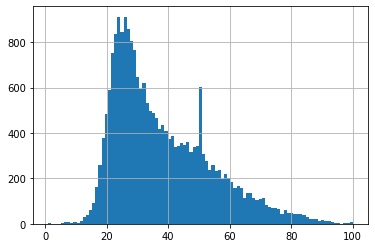

In [17]:
histogram = df['age'].hist(bins=df['age'].nunique())


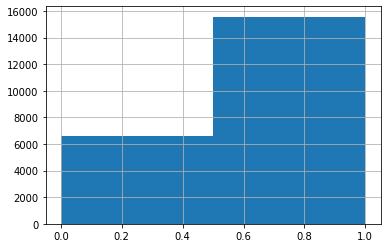

In [18]:
histogram_gender = df['gender'].hist(bins=df['gender'].nunique())

In [19]:
df['gender'].value_counts().sort_index()
#0: woman, 1: man

0.0     6573
1.0    15565
Name: gender, dtype: int64

# Builidng the model for age first
# There are 101 classes in the output layer for ages 0 to 100.


In [17]:
classes = 101 #(0, 100])
print("number of output classes: ",classes)

number of output classes:  101


# Getting Pixels For images

In [18]:
target_size = (224, 224)


def getImagePixels(directory):
    features = dict()
    for name in listdir(directory):
        img = image.load_img(directory + "/%s" % image_path[0], grayscale=False, target_size=target_size)
        x = image.img_to_array(img).reshape(1, -1)[0]
        image_id = name.split('.')[0]
        features[image_id] = x
    return features

# Determining the Features,target variable

In [21]:
target = df['age'].values
target_classes = keras.utils.to_categorical(target, classes)

In [22]:
directory = 'wiki_crop'
features = getImagePixels(directory)

features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [23]:
features.shape

(22578, 224, 224, 3)

In [24]:
features /= 255 #normalize in [0, 1]

# Splitting the dataset for train /test

In [25]:
train_x, test_x, train_y, test_y = train_test_split(features, target_classes
                                        , test_size=0.30)#, random_state=42), stratify=target_classes)

# Building a model for age prediction (inspiration taken from VGG-Face Model)

In [26]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))


#  Cut the last convolution layer because it has 2622 units. I need just 101 (ages from 0 to 100) units for age prediction task
# Adding a custom convolution layer consisting of 101 units.



In [28]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

age_model = Model(inputs=model.input, outputs=base_model_output)

# As it is a muilt class classification proble we will keep loss function as categorical_crossentropy and optimizer as adam

In [30]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

age_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

In [31]:
checkpointer = ModelCheckpoint(
    filepath='classification_age_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [ ]:
scores = []

In [112]:
epochs = 250
batch_size = 256

for i in range(epochs):
    print("epoch ",i)
        
    ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
    score = age_model.fit(
        train_x[ix_train], train_y[ix_train]
        , epochs=1
        , validation_data=(test_x, test_y)
        , callbacks=[checkpointer]
    )
        
    scores.append(score)
    
    #restore the best weights
from keras.models import load_model
age_model = load_model("classification_age_model.hdf5")
#saving the model weights
age_model.save_weights('age_model_weights.h5')


# it shows that increasing the epochs will cause overfitting 

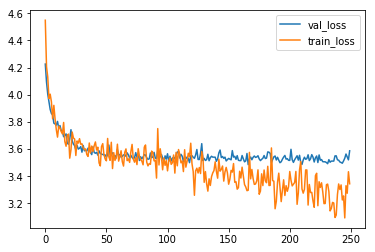

In [48]:
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

# Model evaluation on test set

In [102]:
#loss and accuracy on validation set
age_model.evaluate(test_x, test_y, verbose=1)

6774/6774 [==============================] - 17s 2ms/step


[2.871919590848929, 0.24298789490543357]

#  researchers develop an age prediction approach and convert classification task to regression. They propose that you should multiply each softmax out with its label. Summing this multiplications will be the apparent age prediction.

In [103]:
predictions = age_model.predict(test_x)

In [104]:
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1)

In [105]:
mae = 0

for i in range(0 ,apparent_predictions.shape[0]):
    prediction = int(apparent_predictions[i])
    actual = np.argmax(test_y[i])
    
    abs_error = abs(prediction - actual)
    actual_mean = actual_mean + actual
    
    mae = mae + abs_error
    
mae = mae / apparent_predictions.shape[0]

print("mae: ",mae)
print("instances: ",apparent_predictions.shape[0])

mae:  4.651904340124004
instances:  6774
